In [1]:
from lib.imports import *

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skip_idx = [19,24,26,32,34,38,40,45,52,55,70]
all_idx = list(range(71))
for idx in skip_idx:
    all_idx.remove(idx)
import random
random.seed(0)
random.shuffle(all_idx)
k_folds = 5
foldi = 0
fold_size = int(len(all_idx)/k_folds)
test_idx = all_idx[foldi*fold_size:(foldi+1)*fold_size]
for idx in test_idx:
    all_idx.remove(idx)
train_idx = all_idx

In [3]:
window_size = 101
X,y = load_and_window_nursing_list_for_convolution(train_idx,window_size=window_size)

In [4]:
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=.05,stratify=y)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=64,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=64,shuffle=True)

In [6]:
from torch import nn
device = 'cuda'
model = FCN().to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  266881


100%|██████████| 10/10 [10:36<00:00, 63.64s/it]


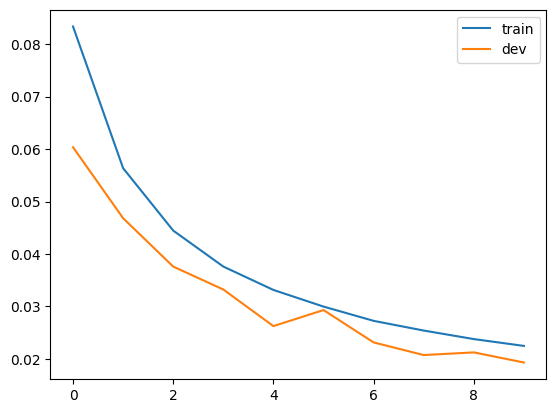

In [7]:
loss_tr = []
loss_dev = []
pbar = tqdm(range(10))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))
plt.plot(loss_tr,label='train')
plt.plot(loss_dev,label='dev')
plt.legend()

100%|██████████| 1044/1044 [00:00<00:00, 1312.63it/s]


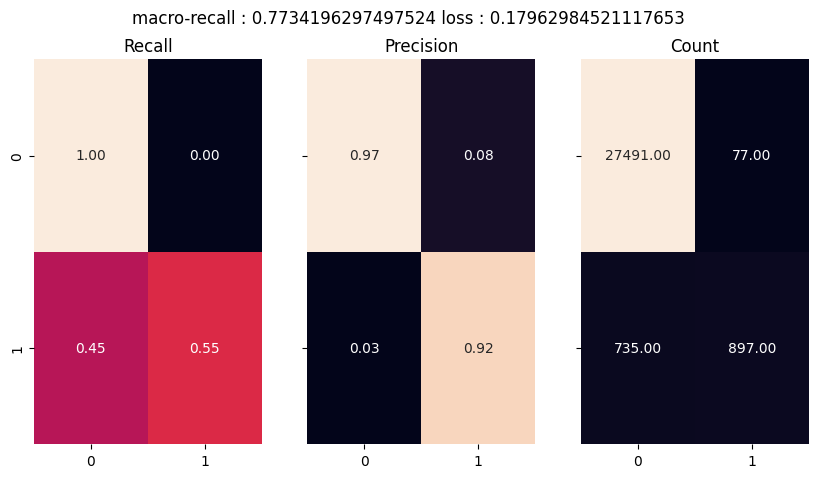

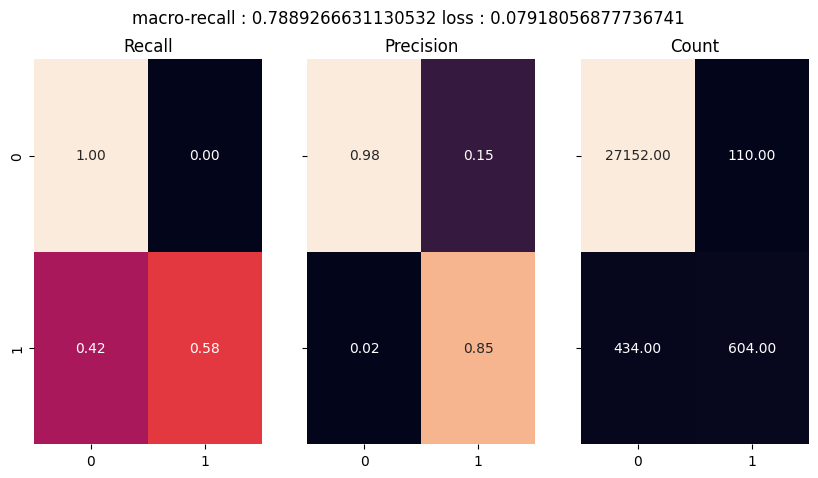

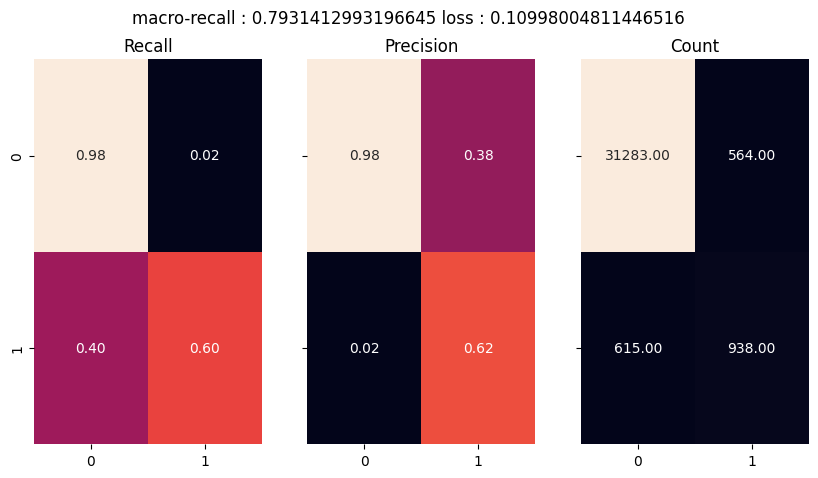

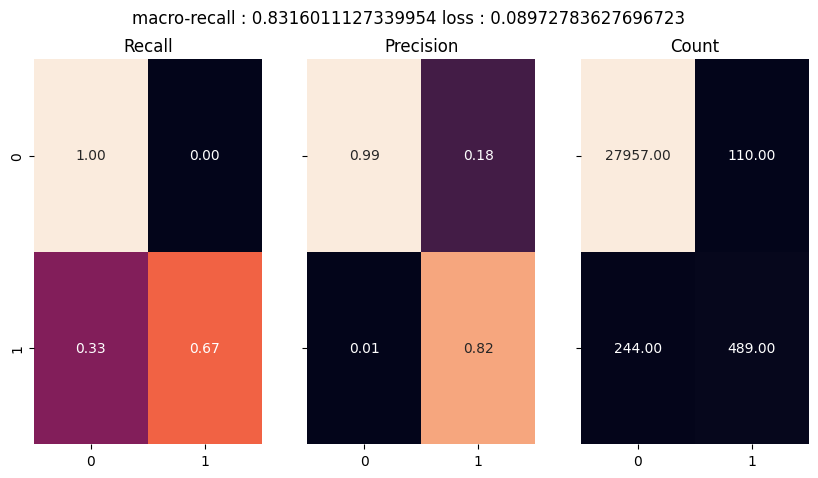

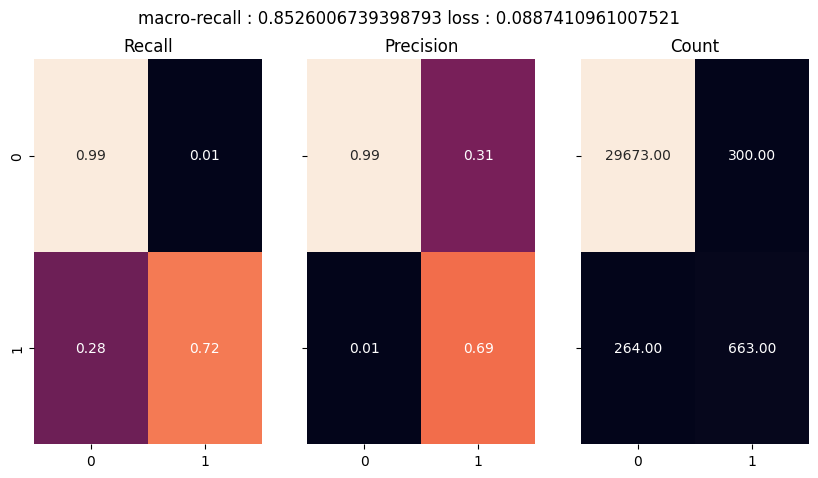

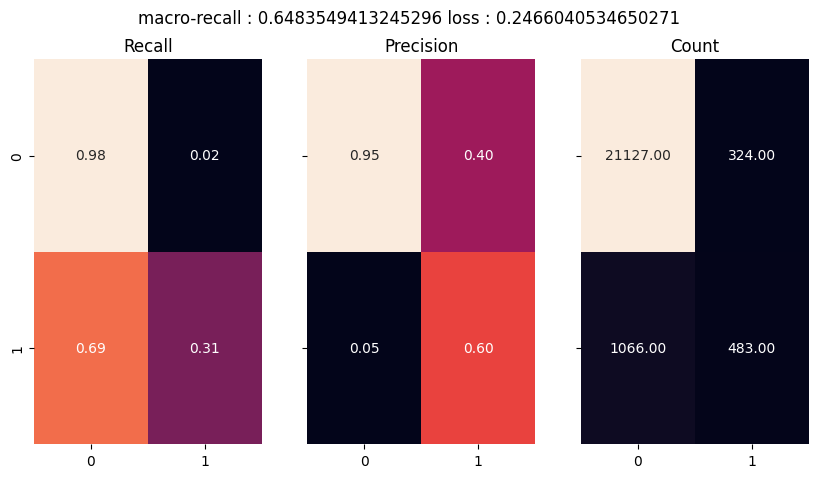

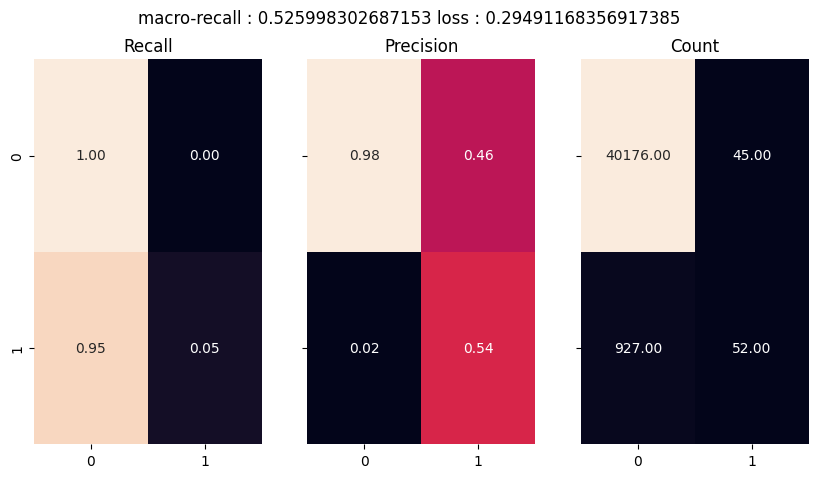

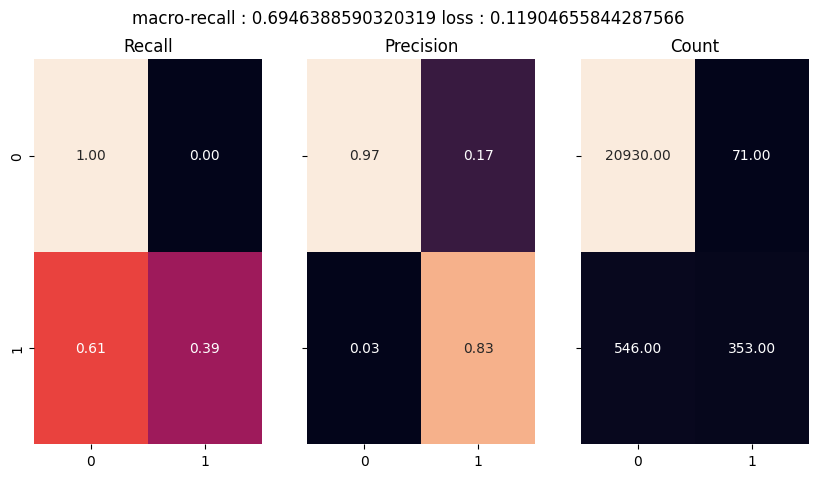

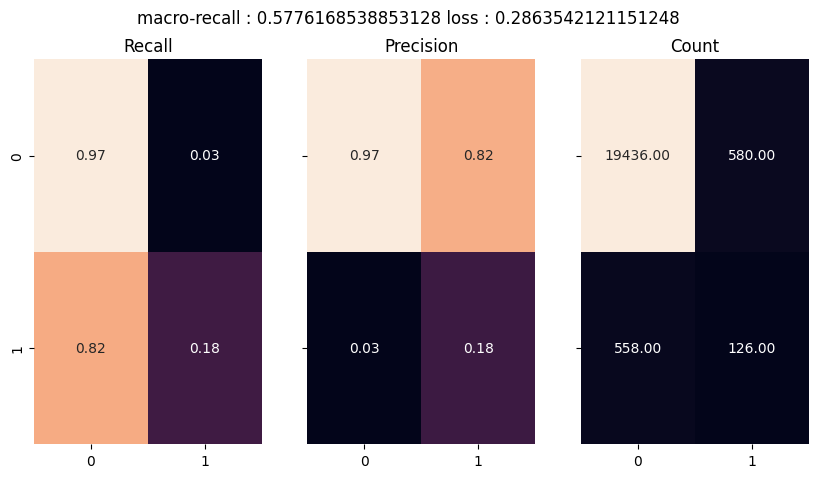

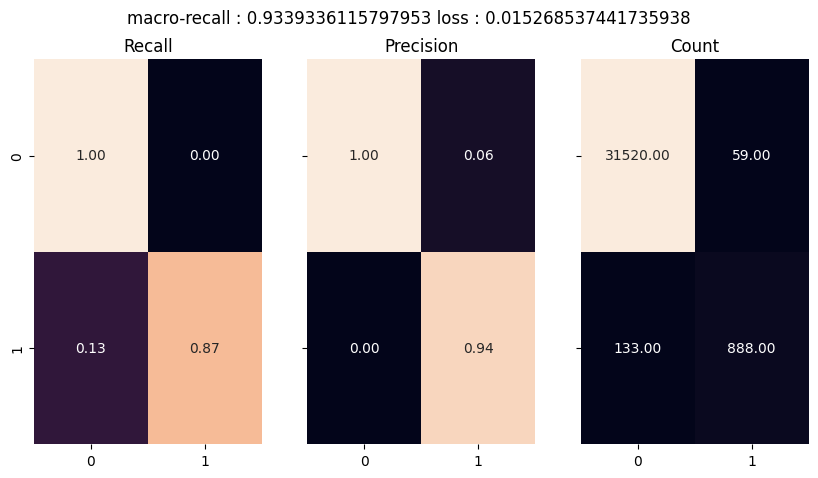

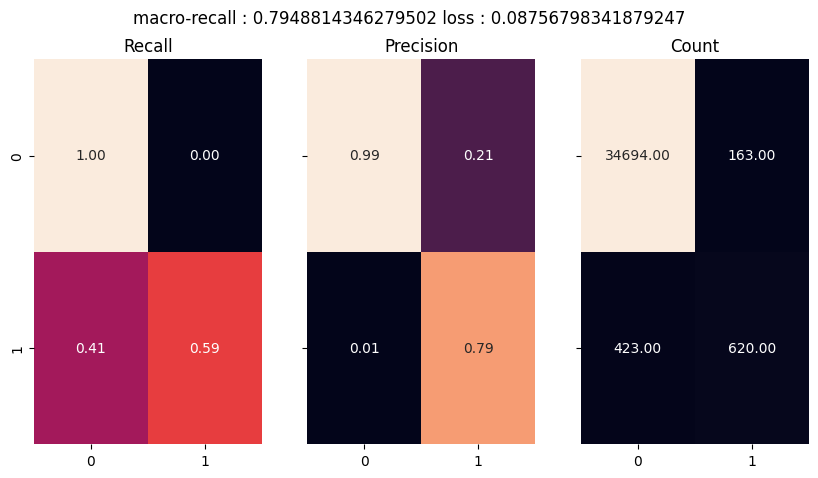

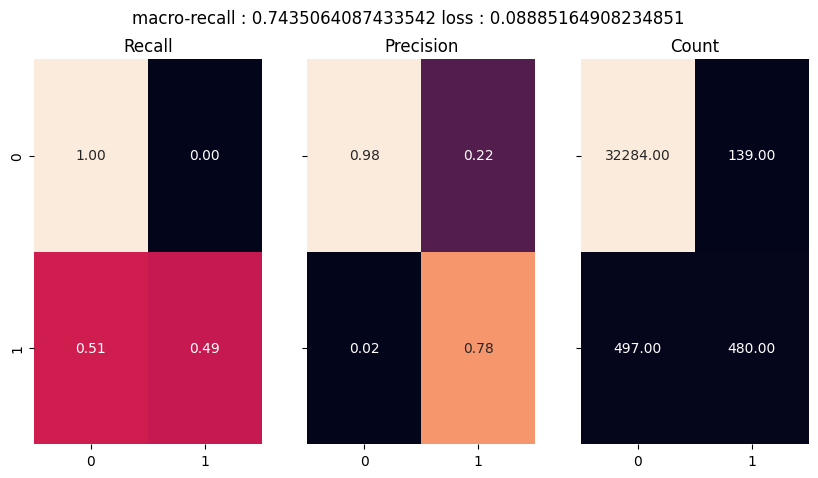

In [21]:
from sklearn.metrics import f1_score,recall_score
f1i = []
recalli = []
for idx in test_idx:
    X,y = load_and_window_nursing_list_for_convolution([idx])
    loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True)
    f1i.append(f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))
    recalli.append(recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro'))

In [22]:
recalli

[0.7734196297497524,
 0.7889266631130532,
 0.7931412993196645,
 0.8316011127339954,
 0.8526006739398793,
 0.6483549413245296,
 0.525998302687153,
 0.6946388590320319,
 0.5776168538853128,
 0.9339336115797953,
 0.7948814346279502,
 0.7435064087433542]

tensor(0.7466, dtype=torch.float64)
tensor(0.1168, dtype=torch.float64)


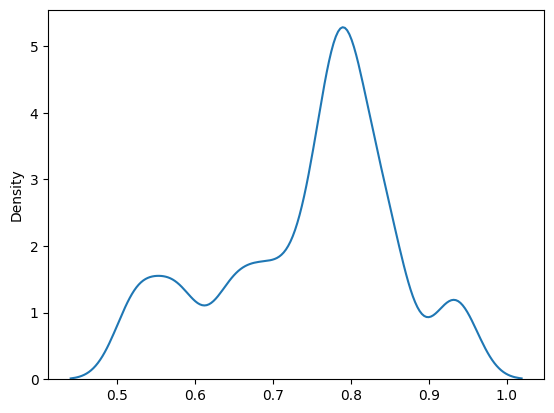

In [30]:
sns.kdeplot(recalli,bw_adjust=.4)
print(torch.tensor(recalli).mean()) #.4958
print(torch.tensor(recalli).std()) #.0063

100%|██████████| 11229/11229 [00:08<00:00, 1254.09it/s]


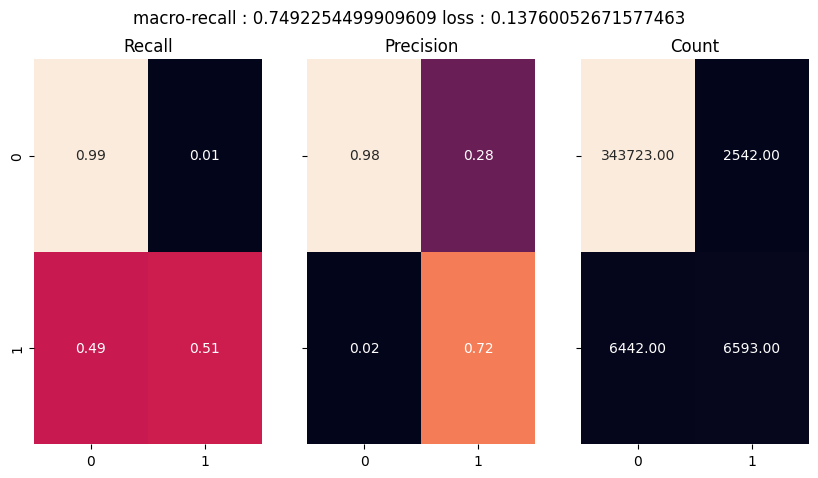

In [26]:
X,y = load_and_window_nursing_list_for_convolution(test_idx)
loss,y_true,y_pred = test_evaluation(DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True),model,criterion,plot=True)

In [27]:
f1_score(y_true=y_true,y_pred=y_pred.round(),average='macro')

0.790933814001119

In [28]:
recall_score(y_true=y_true,y_pred=y_pred.round(),average='macro')

0.7492254499909609